# Transfer Learning
In this notebook, transfer learning will be applied to pre-trained image classification CNN's for a more practical example, namely the classification of surface defects of hot-rolled steel strip.

In [1]:
# Imports
import os 
import copy
import torch
import numpy as np
import torchvision 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

c:\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set model parameters
learning_rate = 0.01
batch_size = 16
epochs = 10

## Dataset analysis 
The dataset, which is downloaded from Kaggle (https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database), is loaded here. Data augmentation is also performed to obtain samples to train on. The dataset is divided in batches of 10. In the end of this section, the batch of images will be visualised

First, the transformations for both the training and validation dataset are defined.

In [3]:
# Normalization parameters (comuted from numerous images)
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

# Define transforms that will be applied to the downloaded images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean,std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean,std)
    ])
}

Next, the data is loaded.

In [4]:
# Image folder object to load images from folders
train_datasets = datasets.ImageFolder(os.path.join('../../data/NEU-DET', 'train'), data_transforms['train'])
valid_dataset = datasets.ImageFolder(os.path.join('../../data/NEU-DET', 'valid'), data_transforms['valid'])
test_datasets = datasets.ImageFolder(os.path.join('../../data/NEU-DET', 'test'), data_transforms['test'])
datasets_dict = {'train': train_datasets, 'valid': valid_dataset, 'test': test_datasets}

# Image dataloaders to load data in batches
train_loader = torch.utils.data.DataLoader(datasets_dict['train'], batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(datasets_dict['valid'], batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets_dict['test'], batch_size=batch_size, shuffle=True)
dataloaders_dict = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

# Get size of datasets
for key in datasets_dict.keys():
   print("In the " + key + " dataset are " + str(len(datasets_dict[key])) + " images")

# Get classes
class_names = datasets_dict['train'].classes
print("These are the classes: " + str(class_names))


In the train dataset are 1374 images
In the valid dataset are 360 images
In the test dataset are 66 images
These are the classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


A function is written to show the images with its corresponding label. 

In [5]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1,2,0))
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

Select a batch of the training data.

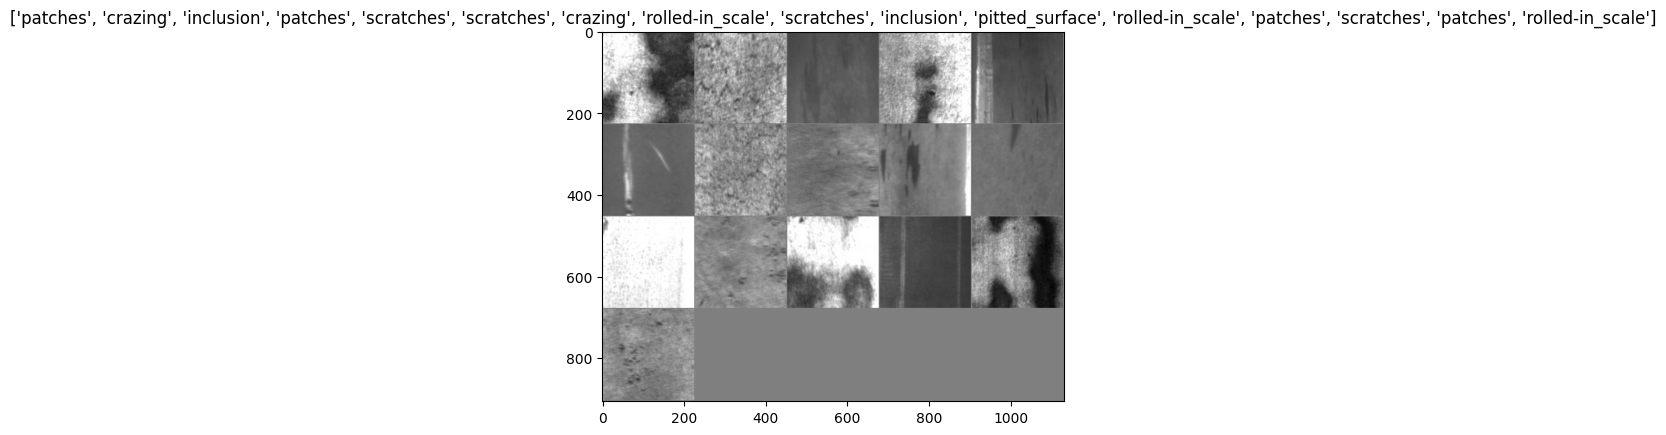

In [6]:
# Extract a batch
batch = next(iter(train_loader))

# Extract the images and labels
x, y = batch

# Make a grid
out = torchvision.utils.make_grid(x, nrow=5) # organizing the images in a grid structure

# Show
imshow(out, title=[class_names[x] for x in y])

## Model training
The transfer learning training loop will be defined here. The training loop is used to train the classification layers of the new model. 

In [7]:
# Search for the available training device on the computer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# This function implements the model training
def train_model(model, criterion, optimizer, n_epochs=25):

    # Learning curves
    results = {"training_acc": [], "training_loss": [], "validation_acc": [], "validation_loss": []}

    # Loop over all epochs
    best_acc = 0
    best_model = []
    for epoch in range(n_epochs):

        # Debug
        print('Epoch {}/{}'.format(epoch+1, n_epochs))
        print('-'*10)

        # Each epoch has a training and validation phase
        for phase in ['train','valid']:

            # Set the network state dependent on the phase
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Reset the losses and corrects at the start of each epoch
            running_loss = 0.0
            running_corrects = 0.0
            
            # Extract batches from the data loaders untill all batches are retrieved
            num_samples = 0
            for inputs, labels in dataloaders_dict[phase]:

                # Inputs shape
                batch_size, c, h, w = inputs.shape

                # Store the inputs and labels to the selected device
                inputs = inputs.to(device)  
                labels = labels.to(device)  

                # Forward pass through the network
                outputs = model(inputs)

                # Softmax transforms the output probabilities into one selected class
                _, class_pred = torch.max(outputs, 1)

                # Compute the loss of the batch
                loss = criterion(outputs, labels)
                
                # Update the losses and corrects for this batch
                running_loss += loss.item() * batch_size
                running_corrects += class_pred.eq(labels).sum().item()

                # Calculate total samples
                num_samples += batch_size

                # If in training phase, adapt the model paramters to account for the losses
                if phase=='train':
                    optimizer.zero_grad() # Pytorch keeps track of the gradients over multiple epochs, therefore initialise it to 0
                    loss.backward() # Calculate the weight gradients (Backward Propagation)
                    optimizer.step() # Update the model parameters using the defined optimizer 
                    
            # Save results
            if phase == 'train':
                results['training_acc'].append((running_corrects/num_samples)*100)
                results['training_loss'].append(running_loss/num_samples)
                print("train_acc %.3f train_loss %.3f" % (running_corrects/num_samples, running_loss/num_samples))
            elif phase == 'valid':
                results['validation_acc'].append((running_corrects/num_samples)*100)
                results['validation_loss'].append(running_loss/num_samples)
                print("val_acc %.3f val_loss %.3f" % (running_corrects/num_samples, running_loss/num_samples))

            # Deep copy the model
            epoch_acc = running_corrects/num_samples
            if phase=='valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = model

    # Print
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    return best_acc, best_model, results

Now, load a pretrained model and reset the final fully connected layer.

In [9]:
# Load pretrained Resnet18 model
model = models.resnet18(pretrained=True)   # change to other models
for param in model.parameters(): param.requires_grad = False  # If feature extractor does not need to be updated
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))    # the outputs are the amount of class labels
model = model.to(device)

In [10]:
# Set the optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Set the loss function
criterion = nn.CrossEntropyLoss()

# Train for 50 epochs
best_acc, best_model, results = train_model(model, criterion, optimizer, n_epochs=epochs)

Epoch 1/10
----------


train_acc 0.717 train_loss 0.888


val_acc 0.933 val_loss 0.380
Epoch 2/10
----------


train_acc 0.885 train_loss 0.433


val_acc 0.936 val_loss 0.276
Epoch 3/10
----------


train_acc 0.910 train_loss 0.322


val_acc 0.925 val_loss 0.266
Epoch 4/10
----------


train_acc 0.908 train_loss 0.304


val_acc 0.925 val_loss 0.237
Epoch 5/10
----------


train_acc 0.930 train_loss 0.247


val_acc 0.944 val_loss 0.208
Epoch 6/10
----------


train_acc 0.929 train_loss 0.245


val_acc 0.922 val_loss 0.263
Epoch 7/10
----------


train_acc 0.922 train_loss 0.228


val_acc 0.922 val_loss 0.239
Epoch 8/10
----------


train_acc 0.937 train_loss 0.214


val_acc 0.936 val_loss 0.185
Epoch 9/10
----------


train_acc 0.927 train_loss 0.219


val_acc 0.936 val_loss 0.195
Epoch 10/10
----------


train_acc 0.938 train_loss 0.188


val_acc 0.936 val_loss 0.213
Best val Acc: 0.9444


In [11]:
# Print results
print("The best validation accuracy is: " + str(best_acc))

The best validation accuracy is: 0.9444444444444444


Text(0.5, 1.0, 'Accuracy')

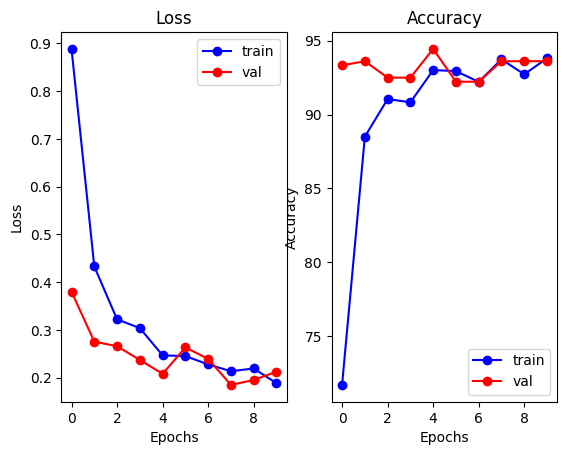

In [12]:
# Plot results
plt.subplot(1, 2, 1)
plt.plot(range(len(results['training_loss'])), results['training_loss'], 'bo-', label='train')
plt.plot(range(len(results['validation_loss'])), results['validation_loss'], 'ro-', label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(len(results['training_acc'])), results['training_acc'], 'bo-', label='train')
plt.plot(range(len(results['validation_acc'])), results['validation_acc'], 'ro-', label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')

## Model validation

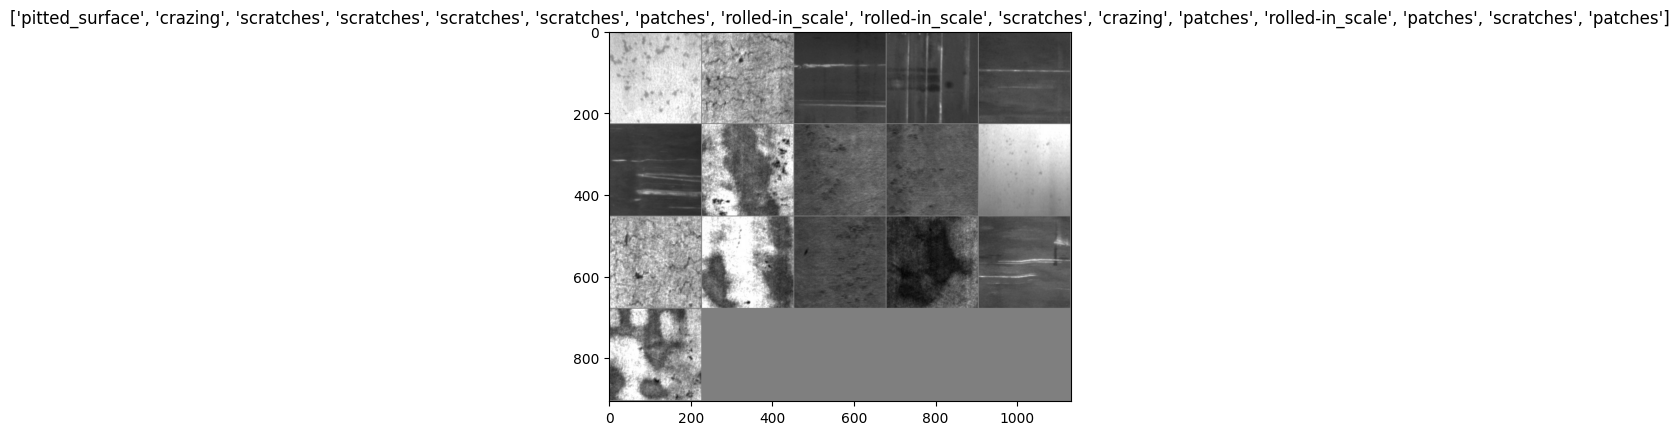

In [13]:
# Put in evaluation mode
best_model.eval()

# Extract a batch
batch = next(iter(test_loader))

# Extract the images and labels
x, y = batch

# Set to device
inputs = x.to(device)
labels = y.to(device)

# Predict
outputs = model(inputs)
_, preds = torch.max(outputs, 1)
predictions = [class_names[preds[j]] for j in range(len(preds))]

# Make a grid
out = torchvision.utils.make_grid(x, nrow=5) # organizing the images in a grid structure

# Show
imshow(out, title=predictions)

In [14]:
# Reset the losses and corrects at the start of each epoch
running_corrects = 0.0

# Extract batches from the data loaders untill all batches are retrieved
num_samples = 0
for inputs, labels in test_loader:

    # Inputs shape
    batch_size, c, h, w = inputs.shape

    # Store the inputs and labels to the selected device
    inputs = inputs.to(device)  
    labels = labels.to(device)  

    # Forward pass through the network
    outputs = model(inputs)

    # Softmax transforms the output probabilities into one selected class
    _, class_pred = torch.max(outputs, 1)
    
    # Update the losses and corrects for this batch
    running_corrects += class_pred.eq(labels).sum().item()

    # Calculate total samples
    num_samples += batch_size

# Print results
print('The model has an accuracy of ' + str((running_corrects/num_samples)*100) + ' on the test set.')

The model has an accuracy of 81.81818181818183 on the test set.
